In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.stats as ss

import elfi
from elfi.examples import bdm
from elfi.examples import gauss

m = gauss.get_model()

from functools import partial

seed = 20170616
n_obs = 50
batch_size = 100
mu, sigma = (5, 1)

# Ptiors
mu0, sigma0 = (5, 1)

y_obs = gauss.Gauss(mu, sigma, n_obs=n_obs, batch_size=1,
                random_state=np.random.RandomState(seed))
sim_fn = partial(gauss.Gauss, sigma=sigma, n_obs=n_obs)

# Posterior
n = y_obs.shape[1]
mu1 = (mu0/sigma0**2 + y_obs.sum()/sigma**2)/(1/sigma0**2 + n/sigma**2)
sigma1 = (1/sigma0**2 + n/sigma**2)**(-0.5)

# Model
m = elfi.ElfiModel(set_current=False)
elfi.Prior('norm', 5, 10, model=m, name='mu')
elfi.Simulator(sim_fn, m['mu'], observed=y_obs, name='Gauss')
elfi.Summary(lambda x: x.mean(axis=1), m['Gauss'], name='S1')
elfi.Distance('euclidean', m['S1'], name='d')

res = elfi.Rejection(m['d'], outputs=['S1'], seed=seed).sample(1000, threshold=1)
la = elfi.LinearAdjustment()
la.fit(m, res, ['mu'], ['S1'])
# adj = elfi.adjust_posterior(m, res, ['mu'], ['S1'])
adj = la.adjust()

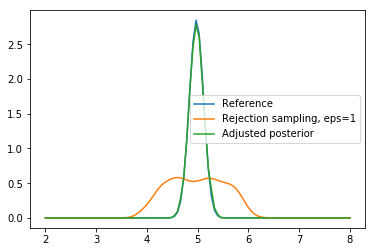

In [8]:
kde_adj = ss.gaussian_kde(adj.outputs['mu'])
kde = ss.gaussian_kde(res.outputs['mu'])

plt.figure()
t = np.linspace(2, 8, 100)
plt.plot(t, ss.norm(loc=mu1, scale=sigma1).pdf(t))
plt.plot(t, kde.pdf(t))
plt.plot(t, kde_adj(t))
plt.legend(['Reference', 'Rejection sampling, eps=1', 'Adjusted posterior'])

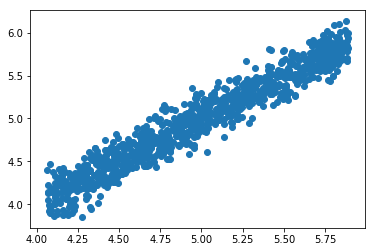

In [9]:
plt.scatter(res.outputs['S1'], res.outputs['mu']);